## 1.Importing libraries

In [40]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

## 2. Data Loading

In [4]:
Main_dir = os.getcwd()
Text_data_dir = Main_dir  #in colab
# Text_data_dir = os.path.join(Main_dir ,'Text_data')   #in vs code

In [42]:
Text_data_Path = os.path.join(Text_data_dir, "text.txt")
text_df = pd.read_csv(Text_data_Path, sep=";", names=['content','sentiment'])
print(f"shape of text data: {text_df.shape}")
text_df.head()

shape of text data: (16000, 2)


,content,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [43]:
#unique sentiments
unique_sentiments = text_df['sentiment'].unique()
print(f"unique sentiments: {unique_sentiments}")

unique sentiments: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


## 3. Analysing data and make it balance

           count  percentage
sentiment                   
joy         5362    33.51250
sadness     4666    29.16250
anger       2159    13.49375
fear        1937    12.10625
love        1304     8.15000
surprise     572     3.57500


<Axes: ylabel='sentiment'>

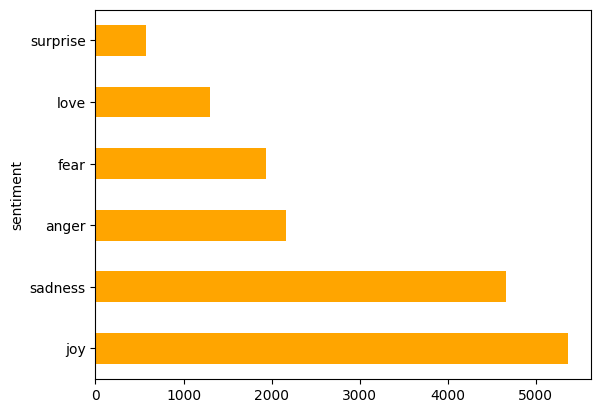

In [44]:
frequency_counts = text_df['sentiment'].value_counts()
frequency_percentage = (frequency_counts / len(text_df['sentiment'])) * 100

# print(frequency_counts)

frequency_df = pd.DataFrame(data={'count' : frequency_counts, 'percentage' : frequency_percentage})
print(frequency_df)

text_df['sentiment'].value_counts().plot(kind='barh',color='orange')

In [45]:
text_df = text_df[text_df.sentiment != "surprise"]

In [46]:
dfs = []
size = len(text_df)

for cls, sub in text_df.groupby("sentiment"):
    if cls in ("sadness", "joy"):
        # down‑sample
        dfs.append(sub.sample(int(0.75 * len(sub)), random_state=23))
    else:
        # keep all of the smaller classes intact
        dfs.append(sub)

text_df = pd.concat(dfs).sample(frac=1, random_state=42)  # shuffle

           count  percentage
sentiment                   
joy         4021   31.122291
sadness     3499   27.082043
anger       2159   16.710526
fear        1937   14.992260
love        1304   10.092879


<Axes: ylabel='sentiment'>

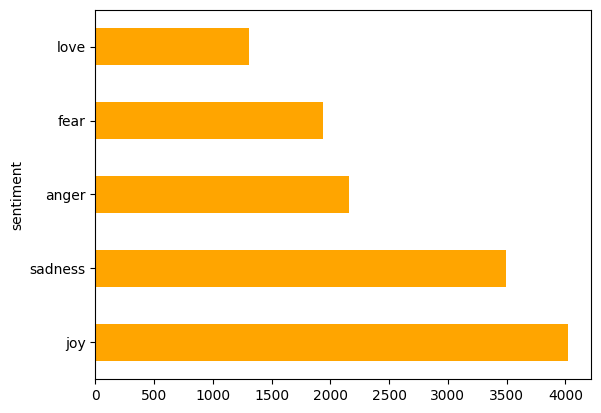

In [47]:
frequency_counts = text_df['sentiment'].value_counts()
frequency_percentage = (frequency_counts / len(text_df['sentiment'])) * 100

# print(frequency_counts)

frequency_df = pd.DataFrame(data={'count' : frequency_counts, 'percentage' : frequency_percentage})
print(frequency_df)

text_df['sentiment'].value_counts().plot(kind='barh',color='orange')

In [48]:
SENTIMENT_CLASS = text_df['sentiment'].unique()
print(f"sentiment classes: {SENTIMENT_CLASS}")

sentiment classes: ['sadness' 'joy' 'anger' 'love' 'fear']


## 4.CLEAN THE DATA

In [49]:
import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def clean_content(text):

    text = re.sub(r'[^a-zA-Z]',' ',text)

    text = re.sub(r'\s+', ' ', text)

    text = text.lower()

    text = text.split()

    text = [word for word in text if word not in stop_words and len(word)>1]

    text = [stemmer.stem(word) for word in text]

    text = " ".join(text)

    return text

print(clean_content("tun 299ijif  npggrgmg % %%$$ v jnnrnr%%8 httpdmfnf//e www.google.com "))

text_df['content'] = text_df['content'].apply(clean_content)
text_df['content'].head()





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tun ijif npggrgmg jnnrnr httpdmfnf www googl com


,content
8702,worri would awkward would feel lone
6252,feel awkward talk book begin
2548,still feel like kid eager blow candl open gift...
11287,wake ill feel realli realli mad
1005,want tell peopl first made feel want think gor...


## 5. Splitting of data into train and test and doing Labeling

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


X_train,X_test,y_train,y_test = train_test_split(text_df['content'], text_df['sentiment'], test_size=0.2, random_state=23,shuffle=True)

text_Encoder = LabelEncoder()
y_train = text_Encoder.fit_transform(y_train)
y_test = text_Encoder.transform(y_test)
SENTIMENT_CLASS_NAMES = text_Encoder.classes_

print(f"Class names: {SENTIMENT_CLASS_NAMES}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



Class names: ['anger' 'fear' 'joy' 'love' 'sadness']
X_train shape: (10336,), y_train shape: (10336,)
X_test shape: (2584,), y_test shape: (2584,)


## 6. Building ML models(Logistic Regression and Decision tree Classifier) and DL model with tfidf Vectoizer techinque

Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

starttime = time.time()

LR_PIPE = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2),min_df =1,smooth_idf=True,norm='l2')),
    ('lr_clf',LogisticRegression(random_state=23))
])

param_grid = {
    'tfidf__max_features': [5000,6000],
    'tfidf__sublinear_tf': [True, False],

    'lr_clf__C': [0.1, 1, 0.5, 2],
    'lr_clf__solver': ['liblinear','saga']
}

grid_search = GridSearchCV(LR_PIPE, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

lr_best_model = grid_search.best_estimator_
y_pred = lr_best_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(f"Time taken: {time.time() - starttime} seconds")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'lr_clf__C': 2, 'lr_clf__solver': 'liblinear', 'tfidf__max_features': 5000, 'tfidf__sublinear_tf': True}
Best score: 0.8734523538819003
Accuracy: 0.8746130030959752
Time taken: 59.39900302886963 seconds


Decision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier

X_train,X_test,y_train,y_test = train_test_split(text_df['content'], text_df['sentiment'], test_size=0.2, random_state=23,shuffle=True)

text_Encoder = LabelEncoder()
y_train = text_Encoder.fit_transform(y_train)
y_test = text_Encoder.transform(y_test)
SENTIMENT_CLASS_NAMES = text_Encoder.classes_

starttime = time.time()

DT_PIPE = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2),min_df =1,smooth_idf=True,norm='l2')),
    ('dt_clf',DecisionTreeClassifier(random_state=23,splitter="best"))
])

param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__sublinear_tf': [True, False],

    'dt_clf__criterion': ['gini', 'entropy'],
    'dt_clf__max_depth': [100,200]
}

grid_search = GridSearchCV(DT_PIPE, param_grid, cv=5,verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

dt_best_model = grid_search.best_estimator_
y_pred = dt_best_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(f"Time taken: {time.time() - starttime} seconds")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'dt_clf__criterion': 'gini', 'dt_clf__max_depth': 200, 'tfidf__max_features': 3000, 'tfidf__sublinear_tf': True}
Best score: 0.8097904905211208
Accuracy: 0.8215944272445821
Time taken: 152.24429869651794 seconds


DL model

X_train shape: (10336, 6000), X_test shape: (2584, 6000)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 30)             │       180,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 120)            │         3,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │         3,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,255 (735.37 KB)

 Trainable params: 187,895 (733.96 KB)

 Non-trainable params: 360 (1.41 KB)

Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.2384 - loss: 2.0733 - val_accuracy: 0.4060 - val_loss: 1.5612
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4488 - loss: 1.3530 - val_accuracy: 0.6153 - val_loss: 1.1534
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6512 - loss: 0.9205 - val_accuracy: 0.7844 - val_loss: 0.6590
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7907 - loss: 0.6076 - val_accuracy: 0.8297 - val_loss: 0.5117
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8676 - loss: 0.4240 - val_accuracy: 0.8324 - val_loss: 0.4916
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8961 - loss: 0.3292 - val_accuracy: 0.8351 - val_loss: 0.5035
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9249 - loss: 0.2491 - val_accuracy: 0.8406 - val_loss: 0.5312
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9397 - loss: 0.2006 - val_accuracy: 0

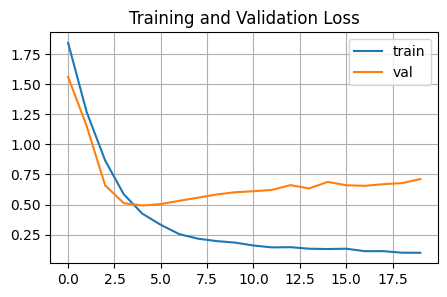

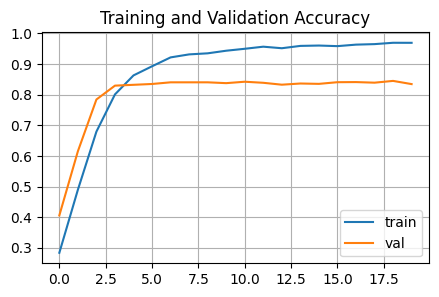

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8207 - loss: 0.7558
accuracy of dl model is 0.8161764740943909


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, smooth_idf=True, norm='l2', max_features=6000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


dlmodel = Sequential()

dlmodel.add(Input(shape=(X_train.shape[1],)))

dlmodel.add(Dense(30, activation='relu'))
dlmodel.add(BatchNormalization())
dlmodel.add(Dropout(0.4))

dlmodel.add(Dense(120, activation='relu'))
dlmodel.add(BatchNormalization())
dlmodel.add(Dropout(0.2))

dlmodel.add(Dense(30, activation='relu'))
dlmodel.add(BatchNormalization())
dlmodel.add(Dropout(0.4))

dlmodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))
dlmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

dlmodel.summary()

es = EarlyStopping(monitor='loss', verbose=1, patience=4,restore_best_weights=True)
hist = dlmodel.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.25, batch_size=32,callbacks=[es])

plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

print(f"accuracy of dl model is {dlmodel.evaluate(X_test, y_test)[1]}")


## 7. Now using SimpleRNN, GRU, LSTM

In [57]:
# USING TOKENIZER AND PAD SEQUENCES
X_train,X_test,y_train,y_test = train_test_split(text_df['content'], text_df['sentiment'], test_size=0.2, random_state=23,shuffle=True)

text_Encoder = LabelEncoder()
y_train = text_Encoder.fit_transform(y_train)
y_test = text_Encoder.transform(y_test)
SENTIMENT_CLASS_NAMES = text_Encoder.classes_


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
# word_index is a dict mapping each word → its assigned integer index

vocab_size = len(word_index)  # number of unique words seen


X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

MAX_LEN = max(len(x) for x in X_train )  # Find the maximum length of sequences

print(f"max len value is {MAX_LEN}")

X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)

max len value is 35
(10336, 35) (2584, 35) (10336,) (2584,)


SimpleRNN

In [58]:
embed_size = 300

In [59]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import SimpleRNN,Embedding,Input,Dropout,Dense
from tensorflow.keras.callbacks import EarlyStopping

rnnmodel = Sequential()
rnnmodel.add(Input(shape=(MAX_LEN,)))#to see parameter count,otherwise model willl not built

rnnmodel.add(Embedding(vocab_size ,embed_size))
rnnmodel.add(SimpleRNN(50, activation='tanh',return_sequences=True))
rnnmodel.add(Dropout(0.3))

rnnmodel.add(SimpleRNN(50, activation='tanh'))
rnnmodel.add(Dropout(0.3))


rnnmodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))  # For binary classification
rnnmodel.summary()

rnnmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True,verbose=1,start_from_epoch=5)
history = rnnmodel.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks=[es])

loss, accuracy = rnnmodel.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 35, 300)        │     2,492,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 35, 50)         │        17,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 35, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,515,555 (9.60 MB)

 Trainable params: 2,515,555 (9.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.2937 - loss: 1.6088 - val_accuracy: 0.4811 - val_loss: 1.3430
Epoch 2/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6239 - loss: 1.0447 - val_accuracy: 0.5861 - val_loss: 1.1648
Epoch 3/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8354 - loss: 0.5221 - val_accuracy: 0.5986 - val_loss: 1.2628
Epoch 4/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9283 - loss: 0.2501 - val_accuracy: 0.5841 - val_loss: 1.4515
Epoch 5/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9571 - loss: 0.1570 - val_accuracy: 0.5967 - val_loss: 1.4724
Epoch 6/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9718 - loss: 0.1061 - val_accuracy: 0.5914 - val_loss: 1.6276
Epoch 7/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9851 - loss: 0.0658 - val_accuracy: 0.6252 - val_loss: 1.6192
Epoch 8/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9865 - loss: 0.0538 - val_accuracy:

GRU

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 35, 300)        │     2,492,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 35, 40)         │        41,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 35, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_27 (GRU)                    │ (None, 40)             │         9,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,543,785 (9.70 MB)

 Trainable params: 2,543,785 (9.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2866 - loss: 1.5563 - val_accuracy: 0.3071 - val_loss: 1.5408
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2986 - loss: 1.5342 - val_accuracy: 0.3071 - val_loss: 1.5386
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3085 - loss: 1.5358 - val_accuracy: 0.3071 - val_loss: 1.5388
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3108 - loss: 1.5379 - val_accuracy: 0.3071 - val_loss: 1.5388
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3201 - loss: 1.4941 - val_accuracy: 0.6165 - val_loss: 0.9177
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7515 - loss: 0.6447 - val_accuracy: 0.8975 - val_loss: 0.3172
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9470 - loss: 0.1748 - val_accuracy: 0.9072 - val_loss: 0.3051
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9727 - loss: 0.0869 - val_accura

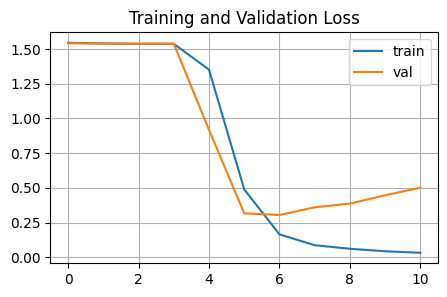

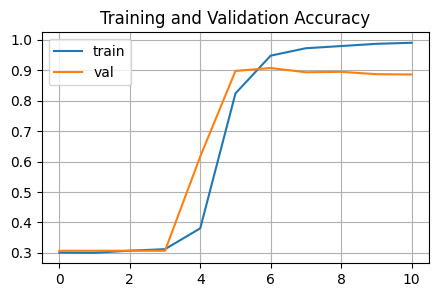

In [65]:
from tensorflow.keras.layers import Embedding,LSTM,GRU

grumodel = Sequential()
grumodel.add(Input(shape=(MAX_LEN,)))

grumodel.add(Embedding(vocab_size,embed_size))

grumodel.add(GRU(40, return_sequences=True))
grumodel.add(Dropout(0.4))
grumodel.add(GRU(40))
grumodel.add(Dropout(0.4))

grumodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))
grumodel.summary()

grumodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True,start_from_epoch=5,verbose=1)
hist = grumodel.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[es])

loss, accuracy = grumodel.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()


LSTM

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 35, 300)        │     2,492,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 35, 50)         │        70,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 35, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,583,355 (9.85 MB)

 Trainable params: 2,583,355 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2961 - loss: 1.5493 - val_accuracy: 0.3071 - val_loss: 1.5433
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3203 - loss: 1.5137 - val_accuracy: 0.4067 - val_loss: 1.2644
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4190 - loss: 1.1828 - val_accuracy: 0.5841 - val_loss: 1.0019
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7259 - loss: 0.7541 - val_accuracy: 0.7974 - val_loss: 0.6679
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8789 - loss: 0.3914 - val_accuracy: 0.8559 - val_loss: 0.5232
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9485 - loss: 0.2128 - val_accuracy: 0.8520 - val_loss: 0.5729
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9427 - loss: 0.2114 - val_accuracy: 0.8651 - val_loss: 0.5442
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9686 - loss: 0.1296 - val_accu

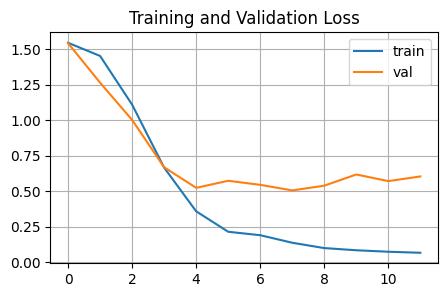

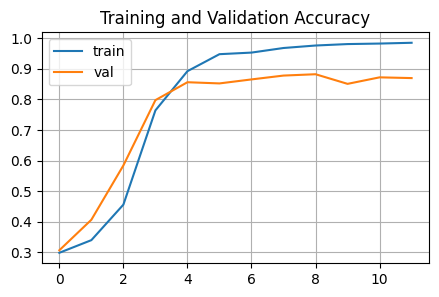

In [79]:
from tensorflow.keras.layers import Embedding,LSTM

lstmmodel = Sequential()
lstmmodel.add(Input(shape=(MAX_LEN,)))

lstmmodel.add(Embedding(vocab_size,embed_size))

lstmmodel.add(LSTM(50, return_sequences=True))
lstmmodel.add(Dropout(0.4))
lstmmodel.add(LSTM(50 ,))
lstmmodel.add(Dropout(0.4))

lstmmodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))
lstmmodel.summary()

lstmmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
hist = lstmmodel.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[es])

loss, accuracy = lstmmodel.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()


## 8. Saving the model

In [82]:
import pickle
import os

# Create the 'models' directory if it doesn't exist
os.makedirs(os.path.join(Main_dir,'models'), exist_ok=True)

pickle.dump(lr_best_model, open(os.path.join(Main_dir,'models','lr_best_model.pkl'), 'wb'))
# pickle.dump(sv_best_model, open(os.path.join(Main_dir,'models','sv_best_model.pkl'), 'wb'))
pickle.dump(text_Encoder,open(os.path.join(Main_dir,'models','text_Encoder.pkl'),'wb'))

#for dl part
# pickle.dump(vectorizer,open(os.path.join(Main_dir,'models','vectorizer.pkl'),'wb'))
# dlmodel.save(os.path.join(Main_dir,'models','dlmodel.h5'))

#tokenizer part
pickle.dump(tokenizer,open(os.path.join(Main_dir,'models','tokenizer.pkl'),'wb'))
pickle.dump(MAX_LEN,open(os.path.join(Main_dir,'models','MAX_LEN.pkl'),'wb'))
lstmmodel.save(os.path.join(Main_dir,'models','lstmmodel.h5'))
grumodel.save(os.path.join(Main_dir,'models','grumodel.h5'))

## 9.Predicting from model

In [7]:
def predict_text_by_mlmodel(text,lr_model,text_Encoder):
    text = clean_content(text) #return string
    text = [text] #vectisers not take string as input so make it list
    y_pred = lr_model.predict(text) #lr model having y of label encode so return number in list ex [2]
    # print(y_pred)             #[2]
    emotion = text_Encoder.inverse_transform(y_pred) #corresponding label name , return list ex ['joy']
    # print(emotion)
    print(f"Predicted emotion: {emotion[0]}")

def predict_text_by_dlmodel(text,lstm_model,text_Encoder,tokenizer,MAX_LEN):
    text = clean_content(text) #return string
    text = [text] #vectisers not take string as input so make it list
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=MAX_LEN, padding='post', truncating='post')
    last_layer_output = lstm_model.predict(text)
    # print(last_layer_output)               #[[0.0716216  0.28323117 0.31504422 0.15884334 0.17125972]] as last layer is softmax return 2d array
    number = np.argmax(last_layer_output,axis=1)  #return 1d array [2]
    emotion = text_Encoder.inverse_transform(number)  #corresponding label name , return list ex ['joy']
    print(f"Predicted emotion: {emotion[0]}")


In [13]:
import pickle
import os 
import tensorflow as tf
import re
from tensorflow.keras.models import load_model
import nltk
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def clean_content(text):

    text = re.sub(r'[^a-zA-Z]',' ',text)

    text = re.sub(r'\s+', ' ', text)

    text = text.lower()

    text = text.split()

    text = [word for word in text if word not in stop_words and len(word)>1]

    text = [stemmer.stem(word) for word in text]

    text = " ".join(text)

    return text

text = "i am feeling happy today and hungry"
lr_best_model = pickle.load(open(os.path.join(Main_dir,'models','lr_best_model.pkl'), 'rb'))
tokenizer = pickle.load(open(os.path.join(Main_dir,'models','tokenizer.pkl'),'rb'))
MAX_LEN = pickle.load(open(os.path.join(Main_dir,'models','MAX_LEN.pkl'),'rb'))
text_Encoder = pickle.load(open(os.path.join(Main_dir,'models','text_Encoder.pkl'),'rb'))


grumodel = tf.keras.models.load_model(os.path.join(Main_dir,'models','grumodel.h5'))
lstmmodel = tf.keras.models.load_model(os.path.join(Main_dir,'models','lstmmodel.h5'))
predict_text_by_mlmodel(text,lr_best_model,text_Encoder)
predict_text_by_dlmodel(text,grumodel,text_Encoder,tokenizer,MAX_LEN)
predict_text_by_dlmodel(text,lstmmodel,text_Encoder,tokenizer,MAX_LEN)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/somesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/somesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/somesh/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/somesh/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-lea

Predicted emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted emotion: joy


In [73]:
#the end